### **Práctica:** Aplicación de filtros FIR para conseguir línea base estable.

<div style="text-align: justify;">
En medicina, una onda de pulso se refiere a la propagación del flujo sanguíneo desde el corazón a través de los vasos sanguíneos, que puede ser detectada y observada como una serie de pulsaciones o latidos rítmicos en diferentes puntos del cuerpo. Estas pulsaciones son provocadas por el bombeo de sangre desde el corazón, que crea una onda de presión que se desplaza a lo largo de las arterias y otras estructuras vasculares. El pulso se puede sentir en varios puntos del cuerpo, siendo los lugares más comunes la arteria radial (en la muñeca), la arteria carótida (en el cuello) y la arteria femoral (en la ingle). El pulso se mide generalmente en latidos por minuto (bpm) y es un indicador importante de la frecuencia cardíaca, que representa la cantidad de veces que el corazón late por minuto.

<div style="text-align: center;">
<img src="../figures/pulso.jpg" width="400">
<img src="../figures/presion-arterial.jpg" width="500">
</div>
</div>


El objetivo de esta práctica es aplicar los conocimiento adquiridos sobre el diseño de filtros FIR para diseñar un Filtro que permita conseguir una línea base estable en un registro de onda de pulso.

**Actividades:**
 1. Se descarga el archivo 'BPW.npz', el cual contiene una
señal de onda de presión arterial obtenida de la base de datos de Physionet, y además contiene el dato de frecuencia de muestreo de la señal.
2. Obtener la FFT de la señal
3. Para lograr una línea base estable en la señal, se debe realizar un filtro pasa altas, el cual lo primero que va a conseguir es retirar el componente de DC, y además será util para retirar las oscilaciones de baja frecuencia que ocasionan que la línea base de la señal no sea estable. Utilizando la FFT de
la señal como referencia, se propone una frecuencia de corte para el filtro con valor de 5 Hz.
4. Al aplicar el filtro diseñado, pero sin realizar la compensación de fase, se observa que el filtro ha logrado establecer una línea base estable en la señal y además ha logrado retirar el offset.
5. Al aplicar un filtrado con compensación de fase se obtiene que la señal filtrada esta en fase con la señal original, pero tambien se observa que la señal filtrada sufre una pequeña deformación respecto a la original, esto se debe a que el proceso de compensación de fase realiza un segundo filtrado, lo cual genera un efecto de duplicación del orden del filtro.


**Código**

Sin embargo, primeramente como una buena practica de programación es necesario importar y declarar las liberias y las funciones que se utilizarán.

Importación de librerías y funciones necesarias


In [1]:
"""Importación de librerías y funciones necesarias"""
import os
import numpy             as np
import matplotlib.pyplot as plt
from   scipy.signal      import firwin, freqz, lfilter, filtfilt

Declaración de funciones

In [2]:
""""Función para estimación de FFT"""
def FFT(senal,sr): 
    f = np.fft.fft(senal) #Obtención de FFT
    h = (np.abs(f))[:f.shape[0]//2] #Recorte de FFT para retirar periodo repetido
    h = 20*np.log10(h) #Conversión de magnitud a dB
    w = np.linspace(0,sr/2,f.shape[0]//2) #Eje de frecuencias para graficar FFT
    return h, w

In [3]:
"""Función para caracterizaciónn de filtros"""
def freqz_plot(b,a,sr):
    w, h = freqz(b,a)
    h[h==0] = 1E-5 #Caso especial de valores cero para evitar error en logaritmo
    H    = 20*np.log10(np.abs(h)) #Conversión de magnitud a dB
    W    = np.angle(h,deg = True) #Obtención de fase a grados
    w    = np.linspace(0,sr/2,H.shape[0]) #Eje de frecuencias para graficar
    return w, W, H

1. Se descarga el archivo 'BPW.npz', el cual contiene una
señal de onda de presión arterial obtenida de la base de datos de Physionet, y además contiene el dato de frecuencia de muestreo de la señal.

In [4]:
"""Obtención del path de datos"""
datapath = os.path.abspath('../signals/')

"""Configuración de path src"""
srcpath = os.path.abspath('')

In [5]:
"""Apertura de archivo a procesar"""
data = np.load(datapath + '/BPW.npz')
for i in data.keys():
    print(i)

BPW
sr


In [6]:
"""Obtención de información dentro del archivo"""
sr  = data['sr'] #Frecuencia de muestreo
BPW = data['BPW']#Señal
t   = np.linspace(0,BPW.shape[0]/sr,BPW.shape[0])

In [7]:
print(f"Frecuencia de muestreo: {sr}")

Frecuencia de muestreo: 1000.0


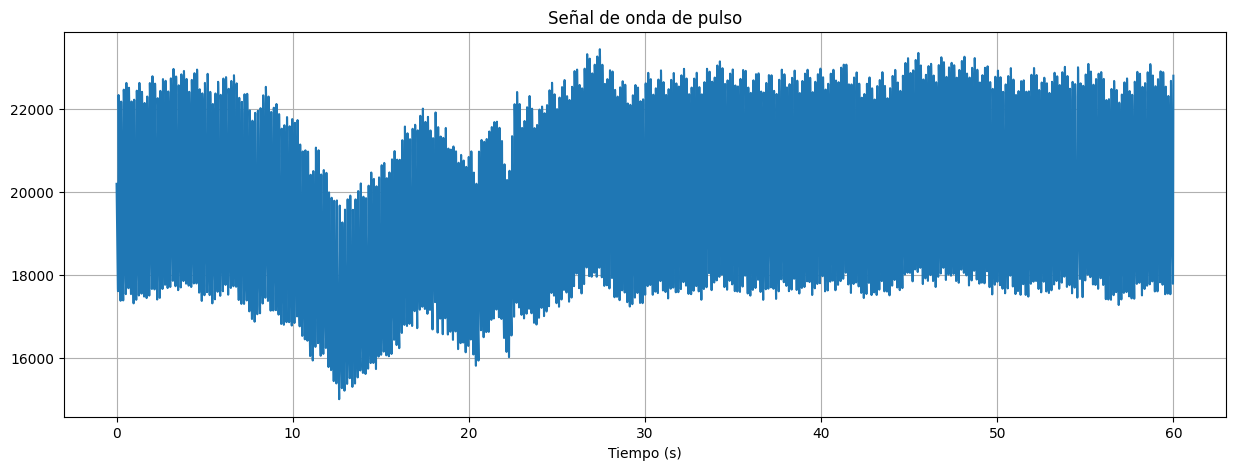

In [8]:
"""Gráfica de señal"""
L = -1 #Variable para control de muestras a visualizar

plt.figure(figsize = (15,5))
plt.plot(t[:L],BPW[:L])
plt.title('Señal de onda de pulso')
plt.xlabel('Tiempo (s)')
plt.grid(True)
# plt.savefig('../figures/pulso.png')
plt.show()

2. Obtener la FFT de la señal

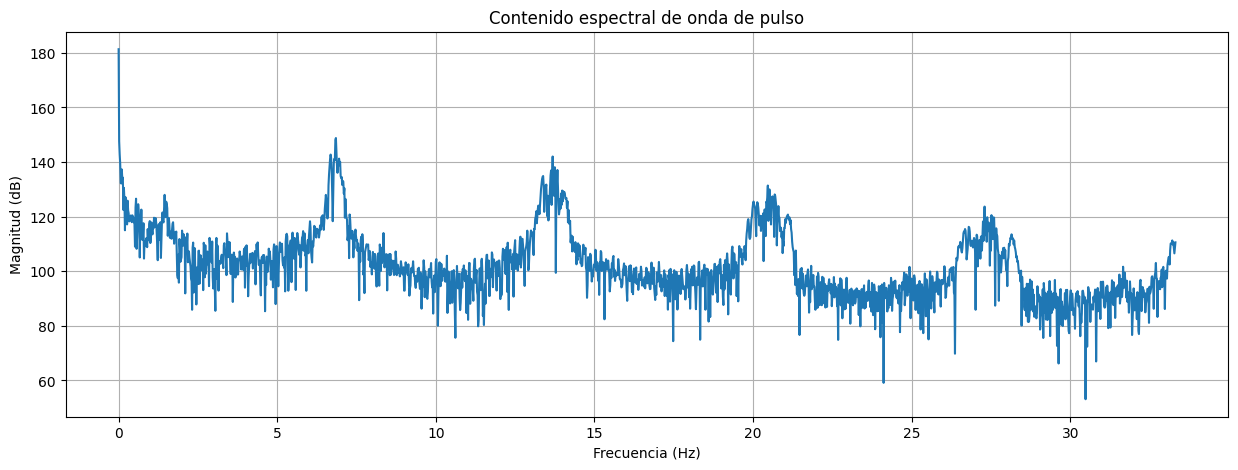

In [9]:
"""Contenido espectral de señal"""
h, w = FFT(BPW,sr)

L = 2000 #Variable para control de muestras a visualizar

plt.figure(figsize = (15,5))
plt.plot(w[:L],h[:L])
plt.title('Contenido espectral de onda de pulso')
plt.xlabel('Frecuencia (Hz)')
plt.ylabel('Magnitud (dB)')
plt.grid(True)
# plt.savefig('../figures/PSD_pulso.png')
plt.show()

**NOTA:**

Al obtener la FFT de la señal se observan dos cosas importantes:

a) Existe un componente de DC con valor cercano a los 180 dB, el cual es el responsable del gran offset que se observa en la señal.

b) Se observa una contribución de ruido (y sus armonicos) cercano a los 7 Hz, la cual se origina debido al procesamiento (incremento de la frecuencia de muestreo) al que fue sometida la señal al momento de generarla.

3. Para lograr una línea base estable en la señal, se debe realizar un filtro pasa altas, el cual lo primero que va a conseguir es retirar el componente de DC, y además será util para retirar las oscilaciones de baja frecuencia que ocasionan que la línea base de la señal no sea estable. Utilizando la FFT de
la señal como referencia, se propone una frecuencia de corte para el filtro con valor de 5 Hz.

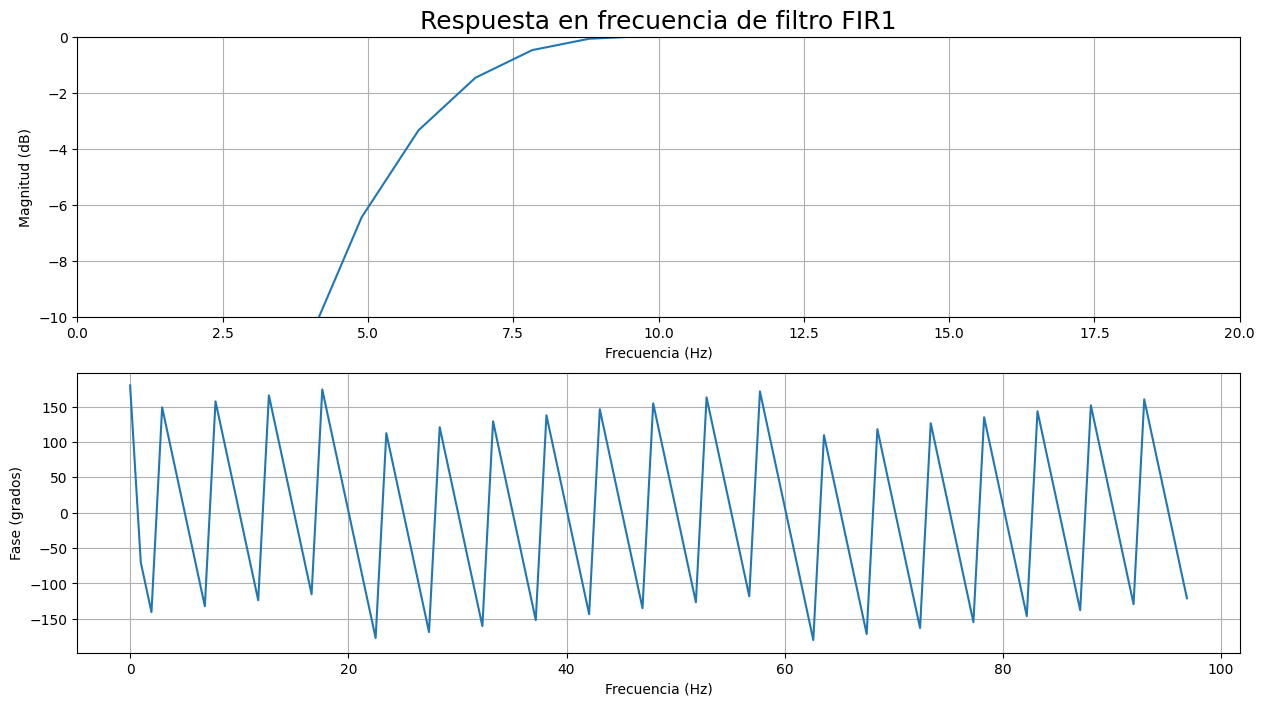

In [10]:
"""Diseño de filtro FIR1"""
#It will be Type I if `numtaps` is odd
#Impar
N = 400
wc = 2*np.array([5])/sr
FIR1 = firwin(N+1, wc, pass_zero=False)

L = 100 #Variable para control de muestras a visualizar

w1,W1,H1 = freqz_plot(FIR1,[1.],sr)

plt.figure(figsize = (15,8))
plt.subplot(211)
plt.title('Respuesta en frecuencia de filtro FIR1',fontsize=18)
plt.plot(w1[:L],H1[:L])
plt.xlabel('Frecuencia (Hz)'), plt.ylabel('Magnitud (dB)')
plt.grid(True)
plt.xlim(0, 20)
plt.ylim(-10, 0)
plt.subplot(212)
plt.plot(w1[:L],W1[:L])
plt.xlabel('Frecuencia (Hz)'), plt.ylabel('Fase (grados)')
plt.grid(True)
# plt.savefig('../figures/FIR1.png')
plt.show()

NOTA: Al caracterizar la respuesta en frecuencia del filtro se puede observar que la frecuencia de corte real del filtro es de aproximadamente 6.5 Hz.

4. Al aplicar el filtro diseñado, pero sin realizar la compensación de fase, se observa que el filtro ha logrado establecer una línea base estable en la señal y además ha logrado retirar el offset.

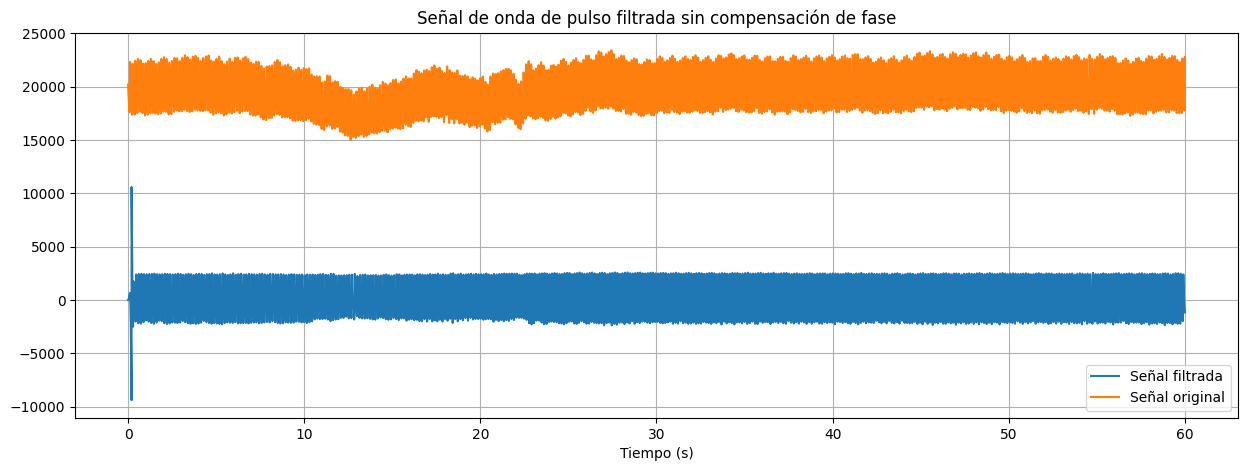

In [11]:
"""Filtrado sin compensación de fase"""
BPW_f1 = lfilter(FIR1,[1.],BPW)

L = -1

plt.figure(figsize = (15,5))
plt.plot(t[:L],BPW_f1[:L])
plt.plot(t[:L],BPW[:L])
plt.title('Señal de onda de pulso filtrada sin compensación de fase')
plt.xlabel('Tiempo (s)')
plt.grid(True)
plt.legend(['Señal filtrada','Señal original'])
# plt.savefig('../figures/pulso_noFase_Off.png')
plt.show()

Nota: Sin embargo, al hacer un zoom en la señal, se observa que se obtiene un retardo de aproximadamente 0.3 segundos en la señal, lo cual genera un desfasamiento en la señal filtrada.

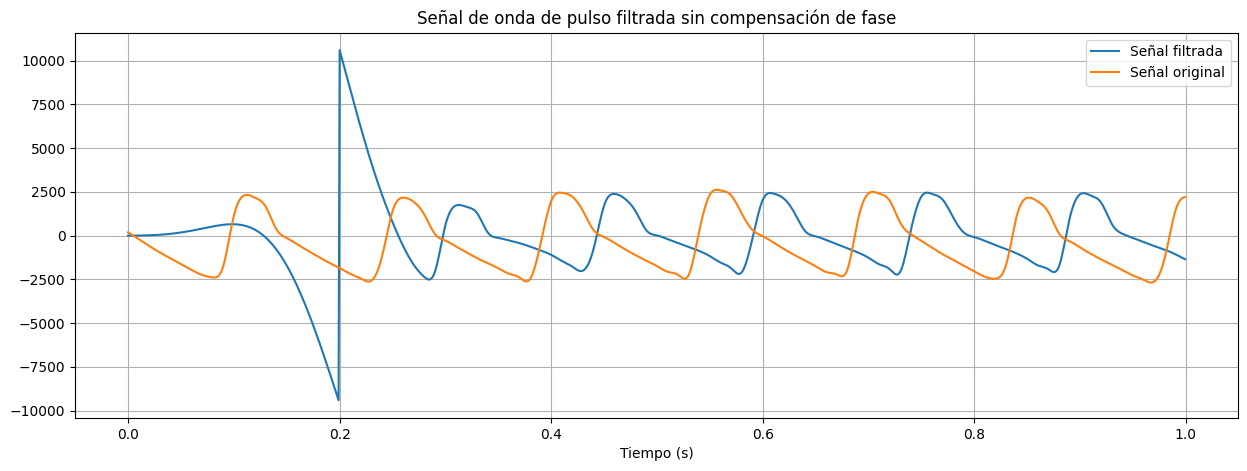

In [12]:
L = 1000

plt.figure(figsize = (15,5))
plt.plot(t[:L],BPW_f1[:L])
plt.plot(t[:L],BPW[:L]-20000) #Se reduce el offset al momento de graficar para poder visualizar mejor los efectos del desfase
plt.title('Señal de onda de pulso filtrada sin compensación de fase')
plt.xlabel('Tiempo (s)')
plt.grid(True)
plt.legend(['Señal filtrada','Señal original'])
# plt.savefig('../figures/pulso_noFase.png')
plt.show()

5. Al aplicar un filtrado con compensación de fase se obtiene que la señal filtrada esta en fase con la señal original, pero tambien se observa que la señal filtrada sufre una pequeña deformación respecto a la original, esto se debe a que el proceso de compensación de fase realiza un segundo filtrado, lo cual genera un efecto de duplicación del orden del filtro.

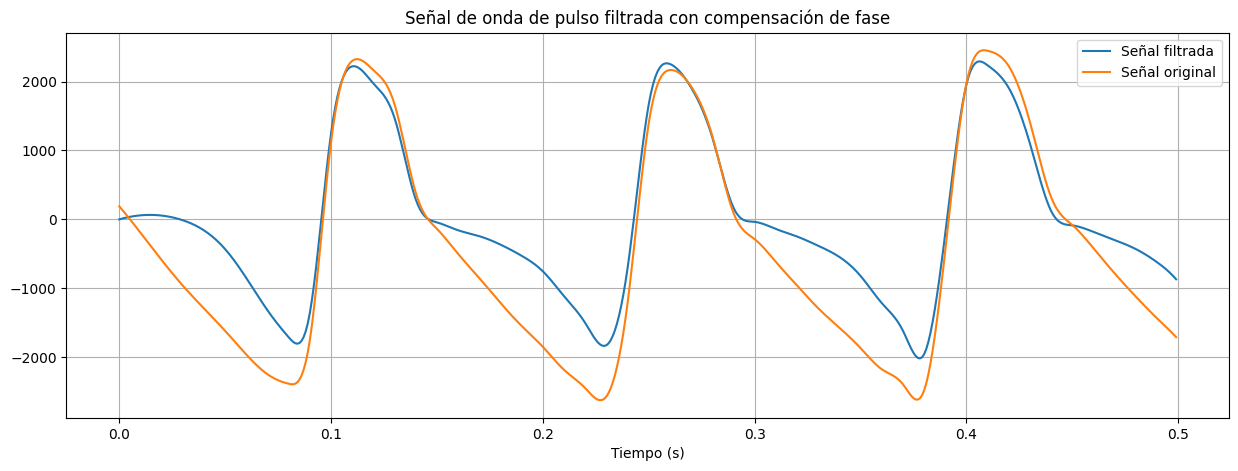

In [13]:
"""Filtrado con compensación de fase"""
BPW_f2 = filtfilt(FIR1,[1.],BPW)

L = 500

plt.figure(figsize = (15,5))
plt.plot(t[:L],BPW_f2[:L])
plt.plot(t[:L],BPW[:L]-20000) #Se reduce el offset al momento de graficar para poder visualizar mejor los efectos del desfase
plt.title('Señal de onda de pulso filtrada con compensación de fase')
plt.xlabel('Tiempo (s)')
plt.grid(True)
plt.legend(['Señal filtrada','Señal original'])
# plt.savefig('../figures/pulso_siFase.png')
plt.show()

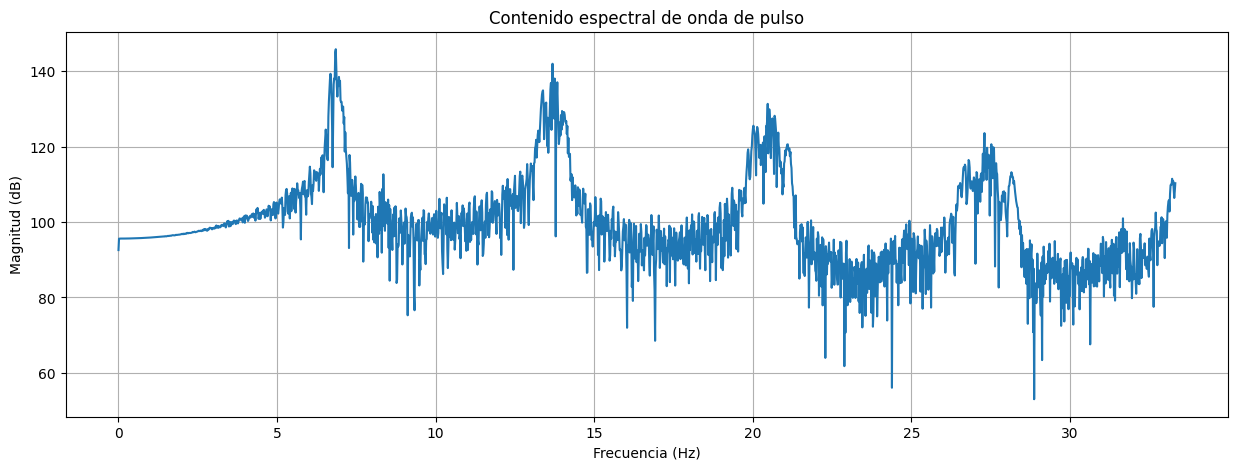

In [14]:
h, w = FFT(BPW_f2, sr)

L = 2000 #Variable para control de muestras a visualizar

plt.figure(figsize = (15,5))
plt.plot(w[:L],h[:L])
plt.title('Contenido espectral de onda de pulso')
plt.xlabel('Frecuencia (Hz)')
plt.ylabel('Magnitud (dB)')
plt.grid(True)
plt.show()